Analysing fitted data : FirstTimeSeen, LastTimeSeen, Dwell Time, addresses detected per second/minute,  x and y coordinates through time

Defining functions

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [2]:
import json 
import math
import numpy as np
import matplotlib.pyplot as plt

def getmeasurementTimestamp(item):
    return int(item['measurementTimestamp'])
def getProcessingTimestamp(item):
    return int(item['processingTimestamp'])

def get_x_error(item): #the error in the data is the stdev of the sample, we compute the error of the estimation (the sample mean)
    return item['value']['averagecoordinate']['error']['coordinates'][0]/math.sqrt(item['value']['trackeeHistory']['nMeasurements'])

def get_y_error(item):
    return item['value']['averagecoordinate']['error']['coordinates'][1]/math.sqrt(item['value']['trackeeHistory']['nMeasurements'])

def get_fitted(item):
     return item['value']['trackeeHistory']['fitStatus']
    
def get_x_sample_error(item): 
    return item['value']['averagecoordinate']['error']['coordinates'][0]
def get_y_sample_error(item):
    return item['value']['averagecoordinate']['error']['coordinates'][1]

def get_probChi2(item):
    return item['value']['trackeeHistory']['probChi2'] 
def get_Chi2PerDof(item):
    return item['value']['trackeeHistory']['chi2PerDof'] 

def plotHistogramOfDictionary(dictionary, xlabel, ylabel, nbins):
    dictionaryList = []
    for address in dictionary.keys():
        dictionaryList.append(dictionary[address])
    dictArray = np.array(dictionaryList)
    plt.hist(dictArray, bins = nbins)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    axes = plt.gca()
    plt.show()
    
def getX(line):
    coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
    return coordinates[0]

def getY(line):
    coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
    return coordinates[1]

Reading fitted data from the concert day

In [3]:
for i in [0]:
    data = []
    with open("/home/ubuntu/ArenaData/arena_fits/2015-07-05.json") as f:
    #with open("arena/2015-07-05_raw.json") as f:
        data = f.readlines()

    json_lines = []
    mac_adresses = []
    
    for line in data:
        jsline = json.loads(line)
        json_lines.append(jsline)#now json_lines contains all lines of data
        mac_adresses.append(jsline["value"]["sourceMac"]) # mac_addresses is a list of address per line
        
#sorting by time
json_lines.sort(key = getmeasurementTimestamp) # now json_lines is sorted by time

Computation of error etc

In [4]:

minTime = getmeasurementTimestamp(json_lines[0])
maxTime = getmeasurementTimestamp(json_lines[len(json_lines) - 1])
print("minTime="+ str(minTime))
print("maxTime="+ str(maxTime))

timeMinutes = (maxTime - minTime)/1000/60

for i in [0]:
    average_x_error = 0
    average_y_error = 0
    count = 0 
    good_lines = []
    number_of_addresses =  len(set(mac_adresses)) #number of mac adresses detected. Not people, because of MAC randomization
    mc_good = []
    delay = 0
    number_of_fitted = 0
    for jsline in json_lines:
        average_x_error += get_x_error(jsline)
        average_y_error += get_y_error(jsline)
        thisdelay = getProcessingTimestamp(jsline) - getmeasurementTimestamp(jsline)
        delay += thisdelay
        if (get_fitted(jsline) == 'FITTED'):
            number_of_fitted +=1
        if get_x_error(jsline) <= 2 and get_y_error(jsline) <= 2:             
            good_lines.append(jsline)
            mc_good.append(jsline["value"]["sourceMac"])
    print('number of addresses the whole day:' + str(number_of_addresses))     
    print('number of fitted:' + str(number_of_fitted))

minTime=1436047367297
maxTime=1436133804311
number of addresses the whole day:30344
number of fitted:772867


Computing FirstTimeSeen and LastTimeSeen for every address

In [5]:
concertFinishedTimestamp=minTime+1000*60*60*8#timestamp until 8 am
FirstTimeSeen=dict()
LastTimeSeen=dict()

for jsline in json_lines:
    address = jsline["value"]["sourceMac"]
    time =  getmeasurementTimestamp(jsline)
    if address in FirstTimeSeen:        
        if time < FirstTimeSeen[address]:
            FirstTimeSeen[address] = time
    else:
        FirstTimeSeen[address] = time
        
    if address in LastTimeSeen:         
        if time > LastTimeSeen[address]:
            LastTimeSeen[address] = time
    else:
        LastTimeSeen[address] = time

Computing dwell time, number of persistent addresses, and number of addresses visible in every second

In [6]:
DwellTime = dict()
DwellTimeDuringConcert = dict()
numberOfAdressesAtConcert=0
for address in LastTimeSeen.keys():    
    DwellTime[address] = int((LastTimeSeen[address] - FirstTimeSeen[address]) /1000/60) # in minutes
    if LastTimeSeen[address] < concertFinishedTimestamp:
        numberOfAdressesAtConcert += 1
        DwellTimeDuringConcert[address] = DwellTime[address]  
print('number of addresses detected during concert hours:')
print(numberOfAdressesAtConcert)
longTermAddresses=[]
numberOfAddresses = []
AddressesInSec = []
for jsline in json_lines:
    sec = int(math.floor((getmeasurementTimestamp(jsline)- minTime)/1000))
    #print(str(sec))
    address = jsline["value"]["sourceMac"]
    if DwellTime[address] > 0:#  i.e. >10 minutes 
        longTermAddresses.append(address)
        if len(AddressesInSec) <= sec:
            while len(AddressesInSec) <= sec:
                AddressesInSec.append([])                
            AddressesInSec[sec].append(address)                       
        else:
            if address not in AddressesInSec[sec]:                                
                AddressesInSec[sec].append(address)
for setje in AddressesInSec:
    numberOfAddresses.append(len(setje)) 
longTermCount = len(set(longTermAddresses))                
print("Long term persistent addresses (>=1 min)= " + str(longTermCount))
average = 0            
maxN = 0
for addresses in AddressesInSec:            
    average += len(addresses) 
    maxN = max(len(addresses), maxN)
average /= len(AddressesInSec)   
print("averageNumberOfAddressesPerSecondAtConcert " + str(average))
print(maxN)

number of addresses detected during concert hours:
28847
Long term persistent addresses (>=1 min)= 16129
averageNumberOfAddressesPerSecondAtConcert 4.881290636062842
40


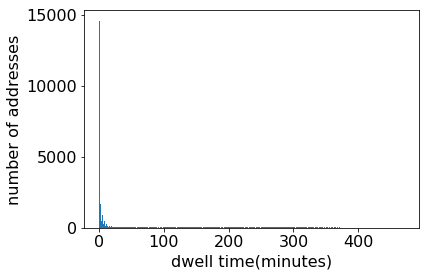

In [7]:
plotHistogramOfDictionary(DwellTimeDuringConcert, "dwell time(minutes)", "number of addresses", 300)

Drawing how many addresses per second are visible (later there is another way to compute this)

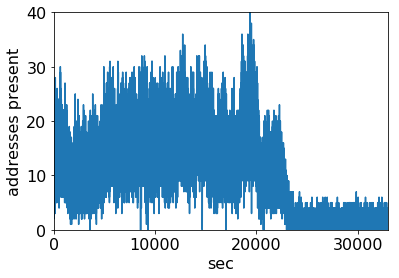

In [8]:
import matplotlib.pyplot as plt
plt.plot(numberOfAddresses)
plt.ylabel('addresses present')
plt.xlabel('sec')
axes = plt.gca()
axes.set_xlim([0,33000])
axes.set_ylim([0,max(numberOfAddresses)])
plt.show()

Just a dictionary that indicates for every address whether it is randomized or not

In [9]:
Randomized = dict()
PersistentRandomized = dict()
count0 = 0
count1 = 0
for line in json_lines:
    address = line["value"]["sourceMac"]
    if line["value"]["trackeeHistory"]["localMac"] == 1 :
        count1 +=1
        Randomized[address] = 1
        if DwellTime[address] > 10: 
            if LastTimeSeen[address] < concertFinishedTimestamp:
                PersistentRandomized[address] = 1 
    else:
        count0 +=1
        Randomized[address] = 0
        if DwellTime[address] > 10: 
            if LastTimeSeen[address] < concertFinishedTimestamp:
                PersistentRandomized[address] = 0 

zeros=0
ones=0
zerosPersistent = 0
onesPersistent = 0
for key in Randomized.keys():
    if Randomized[key]==0:
        zeros +=1
    else:
        ones +=1
for key in PersistentRandomized.keys():
    if PersistentRandomized[key]==0:
        zerosPersistent +=1
    else:
        onesPersistent +=1        
print("total number of lines with localMac == 1: " + str(count1))
print("total number of lines with localMac == 0: " + str(count0))
print("total number of addresses with localMac == 1: " + str(ones))
print("total number of addresses with localMac == 0: " + str(zeros))
print("total number of persistent addresses with localMac == 1: " + str(onesPersistent))
print("total number of persistent addresses with localMac == 0: " + str(zerosPersistent))

total number of lines with localMac == 1: 60024
total number of lines with localMac == 0: 712843
total number of addresses with localMac == 1: 15554
total number of addresses with localMac == 0: 14790
total number of persistent addresses with localMac == 1: 483
total number of persistent addresses with localMac == 0: 9769


In [10]:
DwellTimeConcertRandomized = dict()
DwellTimeConcertNonRandomized = dict()
for key in DwellTimeDuringConcert.keys():
    if Randomized[key] == 0:
        DwellTimeConcertNonRandomized[key] = DwellTimeDuringConcert[key]
    else:
        DwellTimeConcertRandomized[key] = DwellTimeDuringConcert[key]

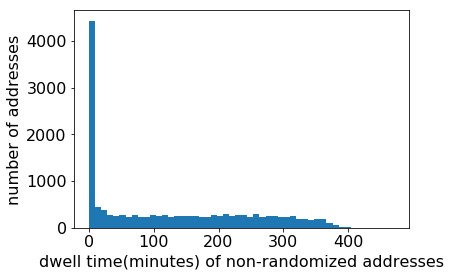

In [11]:
plotHistogramOfDictionary(DwellTimeConcertNonRandomized, "dwell time(minutes) of non-randomized addresses", "number of addresses", 50)

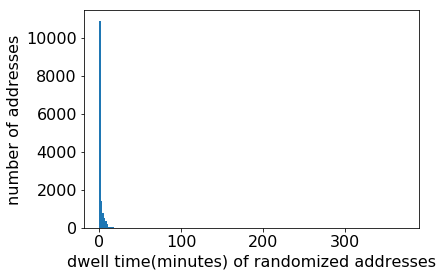

In [12]:
plotHistogramOfDictionary(DwellTimeConcertRandomized, "dwell time(minutes) of randomized addresses", "number of addresses",200)

Double-check:another approach to computing visible addresses per second

In [13]:
Visible = dict()
for line in json_lines:
    address = line["value"]["sourceMac"]
    timeSec = int(math.floor((getmeasurementTimestamp(line)- minTime)/1000))
    if timeSec in Visible.keys():        
        Visible[timeSec].append(address)
    else:
        Visible[timeSec] = []
        Visible[timeSec].append(address)

maxSec = max(Visible.keys())    
print(maxSec)
for sec in range(0,maxSec):
    if sec not in Visible.keys():
        Visible[sec] = []
NVisible = []
for sec in range(0,86437):
    NVisible.append(len(set(Visible[sec])))

86437


Computes visible addresses per time_interval with a specified localMac tag, time_interval in seconds

In [14]:
def ComputeVisiblePerTimeInterval(json_lines, localMac, time_interval = 60):
    Visible = dict()
    for line in json_lines:
        address = line["value"]["sourceMac"]
        timeSec = int(math.floor((getmeasurementTimestamp(line)- minTime)/1000/time_interval))
        
        if timeSec in Visible.keys():  
            if Randomized[address] == localMac:
                Visible[timeSec].append(address)
        else:
            Visible[timeSec] = []
            if Randomized[address] == localMac:
                Visible[timeSec].append(address)
    maxSec = max(Visible.keys())        
    for sec in range(0,maxSec):
        if sec not in Visible.keys():
            Visible[sec] = []
    NVisible = []
    for sec in range(0,maxSec):
        NVisible.append(len(set(Visible[sec])))
    return NVisible

In [14]:
VisiblePer2MinNonRandomized = ComputeVisiblePerTimeInterval(json_lines, 0, 120)

VisiblePer2MinRandomized = ComputeVisiblePerTimeInterval(json_lines, 1, 120)

In [15]:
VisiblePerMinNonRandomized = ComputeVisiblePerTimeInterval(json_lines, 0, 60)

VisiblePerMinRandomized = ComputeVisiblePerTimeInterval(json_lines, 1, 60)

VisiblePerMinNonRandomized = VisiblePerMinNonRandomized[:360]

VisiblePerMinRandomized = VisiblePerMinRandomized[:360]

In [16]:
x_min = -108 #49 #30 
x_max = -93 #64 #80
y_min = -45 #-41 #-60
y_max = 21 #-31 #-10
interval = 60 # in seconds

# checks if coordinates x,y are in square 
def IsInSquare(x,y,xmin, xmax, ymin, ymax):
    return x>xmin and x<xmax and y>ymin and y<ymax

#checks if the error for a certain line of tracking is very small 
def IsSmallError(line):
    alpha = get_probChi2(line)    
    return  (alpha > 0.3) and (get_x_error(line) <3 ) and  get_Chi2PerDof(line) <1.3

#computes the addresses detected in a given time interval and a given square. The keys are time units. Value a list of addresses
def ComputeAddressesPerTimeIntervalInSquare(json_lines, xmin, xmax, ymin, ymax, interval_in_seconds):
    Visible = dict()
    for line in json_lines:
        x = getX(line)
        y = getY(line)
        address = line["value"]["sourceMac"]
        if IsInSquare(x,y,xmin, xmax, ymin, ymax) and IsSmallError(line) and Randomized[address]==0 and DwellTime[address] < 400: 
        #if  Randomized[address]==0:     
            timeMin = int(math.floor((getmeasurementTimestamp(line)- minTime)/1000/interval_in_seconds))
            if timeMin in Visible.keys():                  
                Visible[timeMin].append(address)
            else:
                Visible[timeMin] = []                
                Visible[timeMin].append(address)                    
    maxMin = max(Visible.keys())        
    for i in range(0,maxMin):
        if i not in Visible.keys():
            Visible[i] = []
    return Visible    

#keys are time units. values are number of distinct  addresses detected
def ComputeNumbersOfVisibleAddressesPerTimeIntervalInSquare(json_lines, xmin, xmax, ymin, ymax, interval_in_seconds):
    Visible =  ComputeAddressesPerTimeIntervalInSquare(json_lines, xmin, xmax, ymin, ymax, interval_in_seconds)
    maxTime = max(Visible.keys())        
    NVisible = []
    for i in range(0,maxTime):
        NVisible.append(len(set(Visible[i])))
    return NVisible

#computes the Jaccard similarity between two sets
def JaccardSimilarity(set1, set2):    
    intersect = set1.intersection(set2)
    un = set1.union(set2)
    if len(un) > 0:        
        return len(intersect)/len(un)
    else:
        return 1
   
def JaccardSimilarityModified(set1, set2):    
    intersect = set1.intersection(set2)
    un = set1.union(set2)
    minlength = min(len(set1), len(set2))
    if minlength > 0:        
        return len(intersect)/minlength
    else:
        return 1

#For every two consecutive sets of nonrand addresses detected in a time interval, computes a Jaccard. The array is an ordered list of the
#jaccards
def ComputeArrayOfJaccards(xmin, xmax, ymin, ymax, interval_in_seconds):
    mydict = ComputeAddressesPerTimeIntervalInSquare(json_lines, xmin, xmax, ymin, ymax, interval_in_seconds)
    similarities = []
    firstkey = 0
    for key in sorted(mydict):  
        secondkey = key
        simil = JaccardSimilarity(set(mydict[firstkey]), set(mydict[secondkey]))
        similarities.append(simil)
        firstkey = key                                           
    return similarities



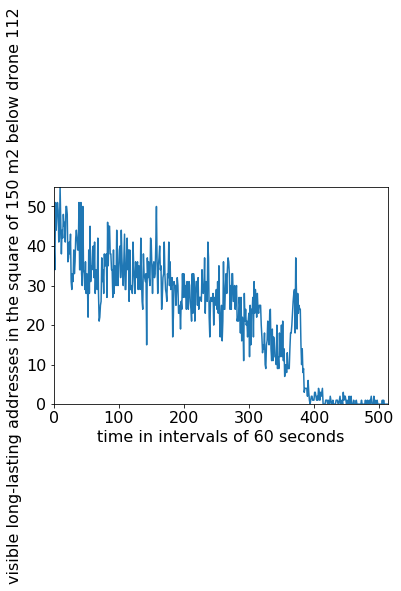

In [17]:
###*************************************************************************************************************
#drawing how many addresses per time interval are visible in the square
import matplotlib.pyplot as plt
VIsiblePerMinInSquare = ComputeNumbersOfVisibleAddressesPerTimeIntervalInSquare(json_lines, x_min, x_max, y_min, y_max, interval)
plt.plot(VIsiblePerMinInSquare)
plt.ylabel('visible long-lasting addresses in the square of 150 m2 below drone 112')
plt.xlabel('time in intervals of ' + str(interval) + ' seconds')
axes = plt.gca()
axes.set_xlim([0,1440*60/2.8/interval])
axes.set_ylim([0,max(VIsiblePerMinInSquare)])
plt.show()

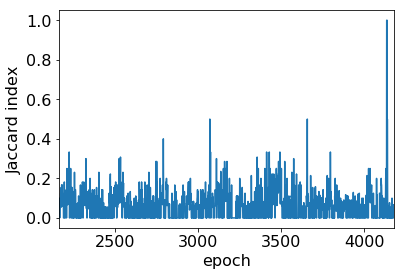

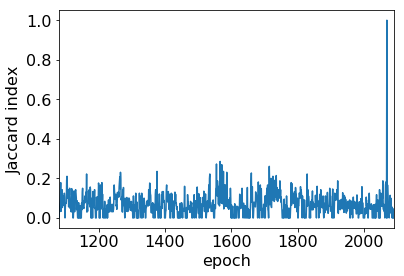

In [27]:
#drawing similarities of consecutive sets of addresses.
import matplotlib.pyplot as plt
import numpy
means = []
errors = []
intervals =[]
x_min = 39 #49 
x_max = 54 #64 
y_min = -39 #-41 
y_max = -24 #-31
for i in range(1,40):
    interval = i*5#in seconds
    intervals.append(interval)
    similarities = ComputeArrayOfJaccards(x_min, x_max, y_min, y_max, interval)
    if i < 10: 
        plt.plot(similarities)
    min_x = int(3600*3.0/interval)
    max_x = int(3600*5.8/interval)
    meanSim = numpy.mean(similarities[min_x:max_x])
    stdSim = numpy.std(similarities[min_x:max_x])
    means.append(meanSim)
    errors.append(stdSim)
    #print(meanSim)
    #print(stdSim)   
    if i < 3:
        plt.ylabel('Jaccard index')
        plt.xlabel('epoch')
        axes = plt.gca()
        axes.set_xlim([min_x, max_x])
        plt.show()

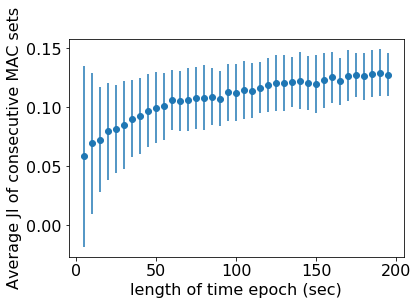

In [59]:
#plot the jaccard similarities

fig, (ax0) = plt.subplots(nrows=1, sharex=True)
ax0.errorbar(intervals, means, yerr=errors, fmt='o')
#ax0.errorbar(times, x_coord, yerr=x_errors, fmt='o')
#ax0.set_title('Average JI of consecutive MAC sets')
plt.xlabel('length of time epoch (sec)')
plt.ylabel('Average JI of consecutive MAC sets')
#ax1.errorbar(times, y_coord, yerr=y_errors)
#ax1.errorbar(times, y_coord, yerr=y_errors, fmt='o')
#ax1.set_title('y-coordinate with error')

plt.show()

drawing how many nonrandomized addresses per  minute are visible

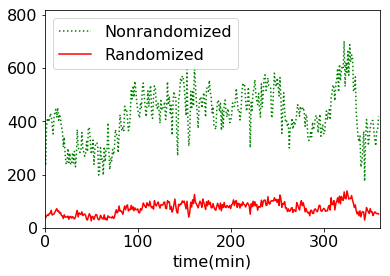

In [38]:
plt.plot(VisiblePerMinNonRandomized, label = "Nonrandomized", color = 'green', linestyle = ':')
plt.plot(VisiblePerMinRandomized, label = "Randomized", color = 'red')
plt.legend(loc = 2, fontsize  = 16)
#ax0_set_title('visible non-randomized and randomized addresses')
plt.xlabel('time(min)')
axes = plt.gca()
axes.set_xlim([0,360])
axes.set_ylim([0,max(VisiblePerMinNonRandomized)+115])
plt.show()

Computing the Pearson correlation coefficient of visible per min randomized and visible per min nonrandomized

In [39]:
from scipy.stats.stats import pearsonr
pearsonr(VisiblePerMinRandomized, VisiblePerMinNonRandomized)

(0.8798610931726063, 1.0275876237052528e-117)

In [40]:
import numpy as np
ratioRandVersusNonRandomVisiblePerMin = np.array(VisiblePerMinRandomized)/np.array(VisiblePerMinNonRandomized)

performing linear regression fit on nonrandomized and randomized addresses per minute

In [41]:
import scipy.stats as st
st.linregress(VisiblePerMinNonRandomized, VisiblePerMinRandomized )

LinregressResult(slope=0.20240407460146223, intercept=-12.473196485953864, rvalue=0.8798610931726064, pvalue=1.0275876237050923e-117, stderr=0.005777877654487358)

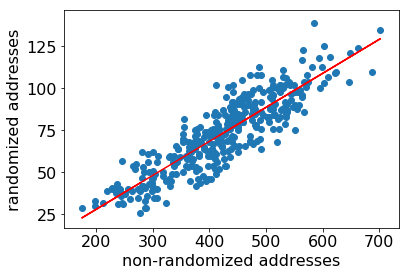

In [52]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

#n = 50

x = np.array(VisiblePerMinNonRandomized)
y = np.array(VisiblePerMinRandomized)

#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


plt.plot(x, fit[0] * x + fit[1], color='red')
plt.scatter(x, y)
plt.ylabel('randomized addresses')
plt.xlabel('non-randomized addresses')
axes = plt.gca()
#axes.set_xlim([0,360])
#axes.set_ylim([0,max(VisiblePerMinNonRandomized)])
plt.show()

In [43]:
# checking the trajectory of a certain address, error used is sample error (not error of the estimation of the mean) 
lines = []#will contain only the lines for that address
for line in json_lines:
    address = line["value"]["sourceMac"]
    #if (address == '27e573c8-1640-4ea8-86d8-0733c800e9cd'):#this is the address we are checking for, non-randomized
    if (address == '3620f07e-a673-4648-bd9b-a0681d574d6f'):
    #if (address == '8b8a2356-d11e-4bd5-bb35-d8370bf48b1e'):#randomized address    
        lines.append(line)
       
x_coord = []
y_coord = []
times = []
x_errors = []
y_errors = []
for line in lines:  
    alpha = get_probChi2(line)    
    if ( alpha > 0.4) and (get_x_sample_error(line) <10 ) and  get_Chi2PerDof(line) <1.1 :    
        coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
        time = math.floor(line["measurementTimestamp"]/1000)      
        if time not in times:       
            x_coord.append( coordinates[0])
            y_coord.append(coordinates[1])
            x_errors.append(get_x_sample_error(line)*2)# for a 95% confidence
            y_errors.append(get_y_sample_error(line)*2)# for a 95% confidence
            times.append(time)
    
print(len(x_errors)) 
print(len(x_coord))

84
84


plotting trajectories and observing bi-modality and multi-modality. we are allowed only to reveal the data for an Access point. We beleive that e1deda99-163f-4b68-9ade-e1f05d070bf2 is an AP  because it was persistent for all 4 days of measurements

In [44]:
# checking the trajectory of a certain address, error used is error of the estimation of the mean
lines = []#will contain only the lines for that address
for line in json_lines:
    address = line["value"]["sourceMac"]
    if address =='e1deda99-163f-4b68-9ade-e1f05d070bf2' : # the largest one, probably an AP     
        lines.append(line)      
x_coord = []
y_coord = []
times = []
x_errors = []
y_errors = []
for line in lines:
    alpha = get_probChi2(line)
    if ( alpha > 0.3) and (get_x_error(line) <5 ) and  get_Chi2PerDof(line) <1.2 :    
        coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
        time = math.floor(line["measurementTimestamp"]/1000)        
        if time not in times:
            x_coord.append( coordinates[0])
            y_coord.append(coordinates[1])
            x_errors.append(get_x_error(line)*2)# for a 95% confidence
            y_errors.append(get_y_error(line)*2)# for a 95% confidence
            times.append(time)
    
print(len(x_errors)) 
print(len(x_coord))

1606
1606


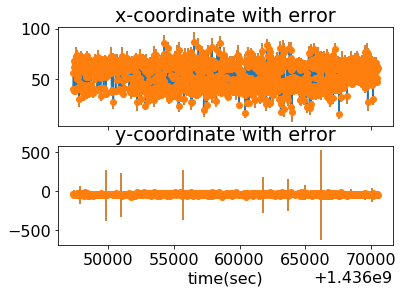

In [51]:
#drawing hte x and y coordinates
import numpy as np
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(times, x_coord, yerr=x_errors)
ax0.errorbar(times, x_coord, yerr=x_errors, fmt='o')
ax0.set_title('x-coordinate with error')
plt.xlabel('time(sec)')

ax1.errorbar(times, y_coord, yerr=y_errors)
ax1.errorbar(times, y_coord, yerr=y_errors, fmt='o')
ax1.set_title('y-coordinate with error')

plt.show()

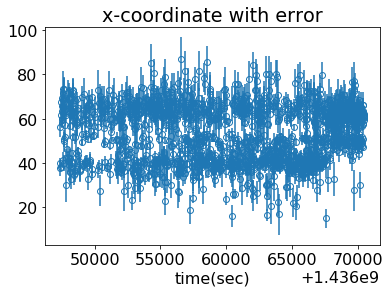

In [58]:
plt.figure()
plt.errorbar(times, x_coord,  yerr=x_errors, fmt='o',fillstyle = "none")
plt.title("x-coordinate with error")
plt.xlabel('time(sec)')

plt.show()

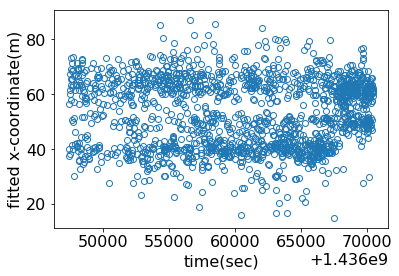

In [67]:
plt.figure()
plt.plot(times, x_coord,  'o', fillstyle = "none")
plt.ylabel("fitted x-coordinate(m)")
plt.xlabel('time(sec)')

plt.show()

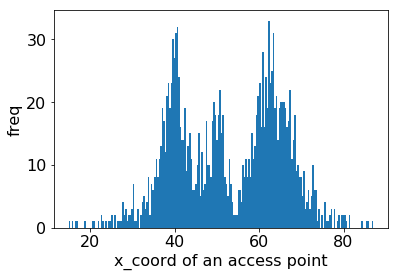

In [46]:
coor = dict()
count =0
for x in x_coord:
    key = times[count]
    coor[key] = x
    count +=1
plotHistogramOfDictionary(coor,  'x_coord of an access point', 'freq', 200)